# NOTEBOOK - 4

# Importing Libraries 

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Importing the dataset 

In [2]:
import pandas as pd
df = pd.read_csv("medical_conditions_dataset.csv")
df

,id,full_name,age,gender,smoking_status,bmi,blood_pressure,glucose_levels,condition
0,1,User0001,NaN,male,Non-Smoker,NaN,NaN,NaN,Pneumonia
1,2,User0002,30.0,male,Non-Smoker,NaN,105.315064,NaN,Diabetic
2,3,User0003,18.0,male,Non-Smoker,35.612486,NaN,NaN,Pneumonia
3,4,User0004,NaN,male,Non-Smoker,NaN,99.119829,NaN,Pneumonia
4,5,User0005,76.0,male,Non-Smoker,NaN,NaN,NaN,Diabetic
...,...,...,...,...,...,...,...,...,...
9995,9996,User9996,NaN,male,Non-Smoker,25.029002,152.540355,137.551451,Pneumonia
9996,9997,User9997,NaN,male,Non-Smoker,27.017487,NaN,NaN,Diabetic
9997,9998,User9998,23.0,male,Smoker,NaN,148.833321,173.931480,Pneumonia
9998,9999,User9999,NaN,female,Non-Smoker,NaN,NaN,NaN,Pneumonia


# 1. Feature Selection & Preprocessing 

1. Problem-Specific Feature Selection
The features chosen should directly relate to smoking behavior. For example:
    
* Age: Smoking habits often vary by age, making it an important feature.
* Gender: Smoking rates differ between genders, so gender is crucial.
* Income: Smoking rates are sometimes higher among lower-income groups.
* Education: Higher education levels tend to correlate with lower smoking rates.
* Occupation: Certain occupations may have higher smoking rates due to stress or social factors.
These features are selected based on their clear connection to smoking behavior.

2. Domain Knowledge
Understanding the problem helps identify key features, even if not immediately apparent statistically. For instance:

* Health variables: Chronic diseases or mental health issues might affect smoking behaviors.
* Social influences: Family or friends who smoke can influence one's smoking habits.

These insights help ensure the model reflects real-world factors affecting smoking.

# Data Cleaning and EDA

In [3]:
# Summary Statistics 
df.describe()

,id,age,bmi,blood_pressure,glucose_levels
count,10000.00000,5445.000000,4652.000000,3766.000000,4756.000000
mean,5000.50000,53.541598,27.423420,135.209429,135.219608
std,2886.89568,20.925113,7.231257,26.041531,37.607638
min,1.00000,18.000000,15.012119,90.009620,70.015961
25%,2500.75000,35.000000,21.077894,113.107754,102.273703
50%,5000.50000,54.000000,27.326204,134.821040,135.436764
75%,7500.25000,72.000000,33.689330,157.949509,168.349011
max,10000.00000,89.000000,39.998687,179.999359,199.890429


In [4]:
# Checking %age of missing values in the dataset 
df.isnull().mean()*100

id                 0.00
full_name          0.00
age               45.55
gender             0.00
smoking_status     0.00
bmi               53.48
blood_pressure    62.34
glucose_levels    52.44
condition          0.00
dtype: float64

Missing Data Summary:
                Missing Count  Missing Percentage
blood_pressure           6234               62.34
bmi                      5348               53.48
glucose_levels           5244               52.44
age                      4555               45.55


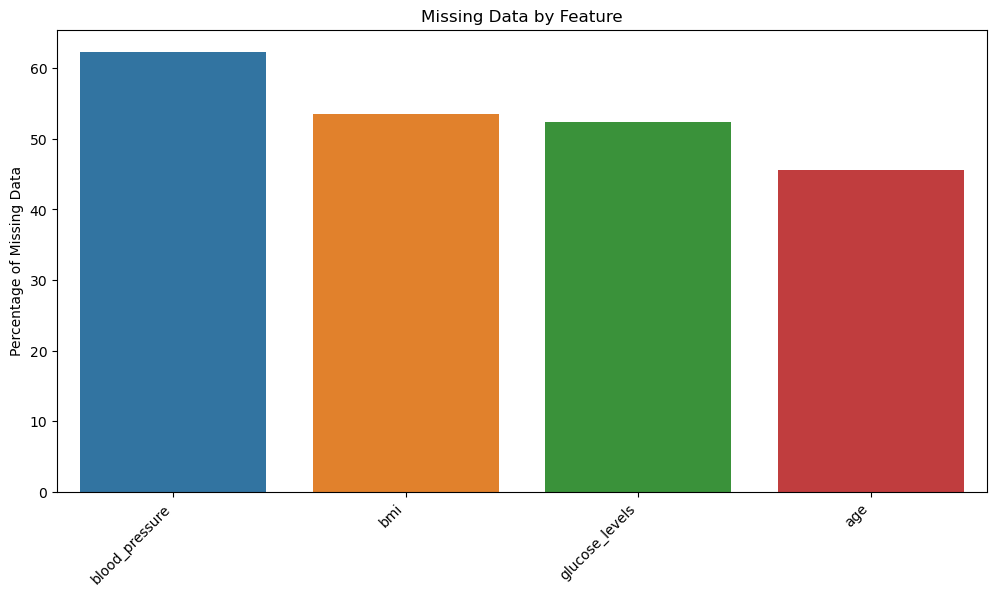

In [5]:
# missing data analysis 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Checking missing values per column
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percentage': missing_percent
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False)
print("Missing Data Summary:")
print(missing_df)

# 2. Visualize percentage of missing data as a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_df.index, y='Missing Percentage', data=missing_df)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage of Missing Data')
plt.title('Missing Data by Feature')
plt.show()


In [6]:
# Data Cleaning

# Dropping unnecessary columns
df.drop(columns=['id', 'full_name'], inplace=True)
# Convert 'age' into integer, marking small values or nulls as NA
df['age'] = df['age'].apply(lambda x: int(x) if pd.notna(x) and x > 1 else pd.NA)
# Drop rows where age is missing
df = df.dropna(subset=['age'])
# Reset index (optional but recommended)
df.reset_index(drop=True, inplace=True)

# Imputation Technique 4 - Random Sample Imputation 

**Random Sample Imputation** is a statistical technique used to handle missing data by replacing missing values in a feature with randomly selected values from the existing (non-missing) data in the same feature column. The key idea is to preserve the original distribution and variability of the data, unlike methods such as mean or median imputation that can reduce variance and introduce bias. This technique is particularly useful when the data is missing at random (MAR) and when maintaining the natural variability of the dataset is important. By sampling from observed values, it avoids the distortion of relationships between variables and keeps the feature’s statistical properties more intact, which can help in maintaining model performance.


In [7]:
def random_sample_imputation(df, column):
    missing_mask = df[column].isnull()
    valid_values = df[column].dropna()
    
    if missing_mask.sum() > len(valid_values):
        # If missing count > available values, enable replacement
        random_sample = valid_values.sample(missing_mask.sum(), replace=True, random_state=42)
    else:
        # Normal sampling without replacement
        random_sample = valid_values.sample(missing_mask.sum(), random_state=42)
    
    df.loc[missing_mask, column] = random_sample.values

# Apply imputation to all columns with missing values
for col in df.columns:
    if df[col].isnull().sum() > 0:
        random_sample_imputation(df, col)


In [8]:
df.isnull().mean()*100

age               0.0
gender            0.0
smoking_status    0.0
bmi               0.0
blood_pressure    0.0
glucose_levels    0.0
condition         0.0
dtype: float64

# Handling Outliers 

In [9]:
# Manually specify numerical columns to check for outliers
numerical_cols = ['age', 'bmi', 'blood_pressure', "glucose_levels"]

# Compute Q1, Q3, and IQR
Q1 = df[['age', 'bmi', 'blood_pressure']].quantile(0.25)
Q3 = df[['age', 'bmi', 'blood_pressure']].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter rows: keep only those that are not outliers in any specified column
df_no_outliers_iqr = df[~((df[numerical_cols] < lower_bound) | (df[numerical_cols] > upper_bound)).any(axis=1)]

# Display how many rows were removed
print(f"Rows before: {df.shape[0]}")
print(f"Rows after outlier removal: {df_no_outliers_iqr.shape[0]}")


Rows before: 5445
Rows after outlier removal: 5445


/var/folders/3z/04dfh84n663cm0t0v83rlcv00000gn/T/ipykernel_4364/3347998392.py:5: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df[['age', 'bmi', 'blood_pressure']].quantile(0.25)
/var/folders/3z/04dfh84n663cm0t0v83rlcv00000gn/T/ipykernel_4364/3347998392.py:6: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df[['age', 'bmi', 'blood_pressure']].quantile(0.75)
/var/folders/3z/04dfh84n663cm0t0v83rlcv00000gn/T/ipykernel_4364/3347998392.py:14: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before 

Conclusion: No outliers were detected in the dataset.

Despite performing outlier detection, the number of rows in the dataset remained unchanged at 5445 both before and after the process. This suggests that the data does not contain values that significantly deviate from the overall pattern or distribution, and therefore, no outliers were identified during the analysis. This indicates that the dataset is relatively clean and does not require further adjustment for outlier removal at this stage.


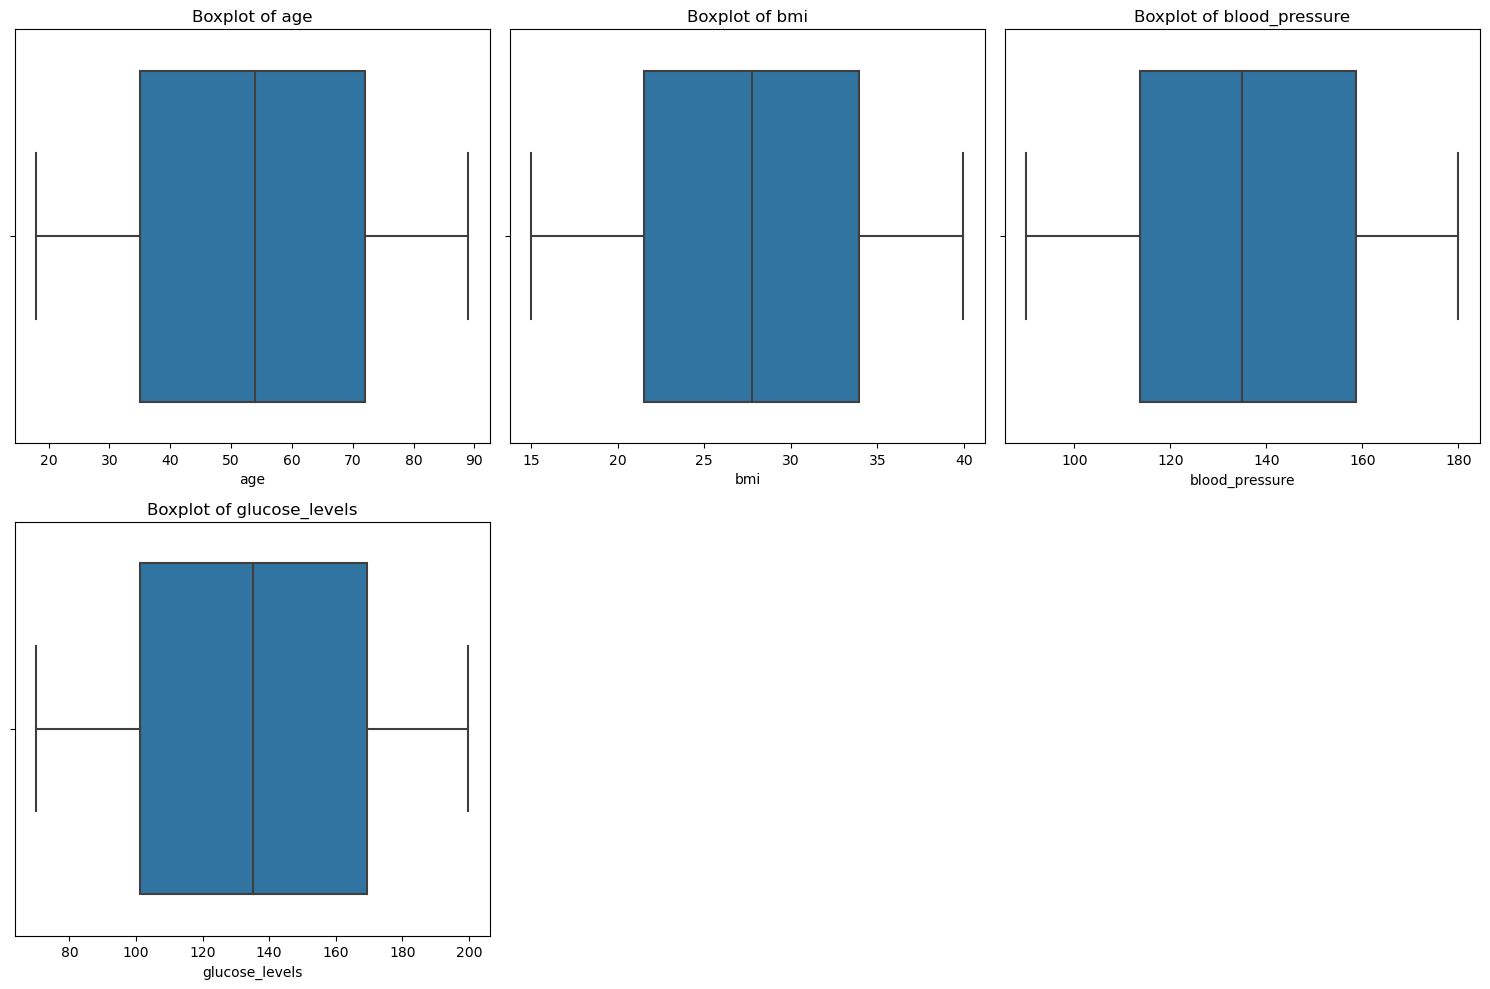

In [10]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot((len(numerical_cols)-1)//3 + 1, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


# Encoding 

In [11]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import pandas as pd

# Step 1: Separate features and target
y = df['smoking_status'] 
encod3 = LabelEncoder()
y = encod3.fit_transform(y) 

# Step 2: Define columns for encoding
onehot_cols = ["gender"]
ordinal_cols = ["condition"]
feature_cols = [col for col in df.columns if col not in (["smoking_status"])]  # all features except target

# Step 3: Define ColumnTransformer
ct = ColumnTransformer(transformers=[
    ('gender_onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), onehot_cols),
    ('condition_ordinal', OrdinalEncoder(categories=[["Diabetic", "Pneumonia", "Cancer"]]), ordinal_cols)
], remainder="passthrough")

# Step 4: Fit and transform only features
X = ct.fit_transform(df[feature_cols])  # Only features, not target

# Step 5: Create column names for the new DataFrame
new_columns = []
new_columns += list(ct.named_transformers_['gender_onehot'].get_feature_names_out(onehot_cols))  # OneHot names
new_columns += ordinal_cols  # Ordinal names
# Passthrough columns: all columns not encoded
passthrough_cols = [col for col in feature_cols if col not in onehot_cols + ordinal_cols]
new_columns += passthrough_cols

# Step 6: Reconstruct final X DataFrame
X = pd.DataFrame(X, columns=new_columns)
X.head()

,gender_female,gender_male,condition,age,bmi,blood_pressure,glucose_levels
0,0.0,1.0,0.0,30,15.294165,105.315064,87.25908
1,0.0,1.0,1.0,18,35.612486,172.988309,186.468906
2,0.0,1.0,0.0,76,21.926526,119.984737,137.44193
3,0.0,1.0,0.0,40,33.840723,162.603987,73.809421
4,0.0,1.0,2.0,49,18.468399,166.759942,153.151126


# Scaling 

In [12]:
from sklearn.preprocessing import StandardScaler
# Specify the columns to scale
columns_to_scale = ['age', 'bmi', 'blood_pressure', 'glucose_levels']
scaler = StandardScaler()
# Fit and transform 
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
df.head()  

/var/folders/3z/04dfh84n663cm0t0v83rlcv00000gn/T/ipykernel_4364/2021023578.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])


,age,gender,smoking_status,bmi,blood_pressure,glucose_levels,condition
0,-1.125144,male,Non-Smoker,-1.724287,-1.173965,-1.261954,Diabetic
1,-1.698670,male,Non-Smoker,1.105948,1.442691,1.359157,Pneumonia
2,1.073374,male,Non-Smoker,-0.800434,-0.606747,0.063871,Diabetic
3,-0.647205,male,Non-Smoker,0.859151,1.041171,-1.617293,Diabetic
4,-0.217060,male,Smoker,-1.282133,1.201865,0.478906,Cancer


# 2. Model Training and Evaluation 

I chose to evaluate **Logistic Regression, Random Forest, and Support Vector Machine (SVM)** models for this dataset to identify the most effective approach for predicting smoking status (smoker or non-smoker). **Logistic Regression** was selected for its simplicity, interpretability, and suitability for binary classification. It provides clear insights into how each feature—such as age, gender, and income—influences the likelihood of smoking, which is valuable for explaining the results. **Random Forest** was included due to its ability to capture complex, non-linear patterns and handle feature interactions automatically, making it robust and less prone to overfitting. It also handles imbalanced data more effectively through its ensemble nature. **SVM** was considered because of its effectiveness in high-dimensional spaces and its strong theoretical foundations for binary classification tasks. By comparing these three models, I was able to balance interpretability, predictive performance, and robustness, ultimately helping to identify the most appropriate model for this classification problem.


# Train Test Split 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Model 1 - Logistic Regression 

In [14]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model

LogisticRegression(max_iter=1000)

# Evaluation Metrics 

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
cm = confusion_matrix(y_test, y_pred)


print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro):    {recall:.4f}")
print(f"F1 Score (Macro):  {f1:.4f}")
print("\nConfusion Matrix:")
print(cm)


Accuracy:  0.9027
Precision (Macro): 0.4513
Recall (Macro):    0.5000
F1 Score (Macro):  0.4744

Confusion Matrix:
[[983   0]
 [106   0]]


# Cross Validation 

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

array([0.90252294, 0.90355913, 0.90241102, 0.90241102, 0.90241102])

# Hyperparameter Tuning using best parameters 

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Define numeric features (already one-hot encoded)
numeric_features = [
    'age', 'bmi', 'blood_pressure', 'glucose_levels', 
    'gender_female', 'gender_male', 'condition'
]

# Preprocessing: scale numeric features only
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features)
], remainder='passthrough')

# Fit and transform X_train, transform X_test
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Train Logistic Regression with best params
final_model = LogisticRegression(
    C=0.01,
    penalty='l2',
    solver='lbfgs',
    max_iter=100,
    fit_intercept=True,
    random_state=42,
    class_weight='balanced'
)
final_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = final_model.predict(X_test_scaled)

# New Evaluation Metrics 

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision (macro)
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision (Macro): {precision:.4f}")

# Recall (macro)
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall (Macro): {recall:.4f}")

# F1 Score (macro)
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score (Macro): {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.3949
Precision (Macro): 0.5067
Recall (Macro): 0.5175
F1 Score (Macro): 0.3494

Confusion Matrix:
[[359 624]
 [ 35  71]]


# Model 2 - Random Forest 

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_model

RandomForestClassifier(random_state=42)

# Evaluation Metrics 

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Train Random Forest with OOB score enabled
rf_model = RandomForestClassifier(random_state=42, oob_score=True)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_rf)

# Precision, Recall, F1 (macro averages for multiclass fairness)
precision = precision_score(y_test, y_pred_rf, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred_rf, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred_rf, average='macro', zero_division=0)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# OOB Score
oob_score = rf_model.oob_score_

# Print metrics
print("Random Forest Classifier Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")
print(f"OOB Score: {oob_score:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Random Forest Classifier Evaluation Metrics:
Accuracy: 0.9027
Precision (Macro): 0.4513
Recall (Macro): 0.5000
F1 Score (Macro): 0.4744
OOB Score: 0.9029

Confusion Matrix:
[[983   0]
 [106   0]]


# Cross Validation 

In [21]:
from sklearn.model_selection import cross_val_score
cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

array([0.90252294, 0.90355913, 0.90241102, 0.90241102, 0.90241102])

# Hyperparameter Tuning using best parameters 

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features)
], remainder='passthrough')

# Create a pipeline with preprocessing and Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Hyperparameter grid for Random Forest
rf_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# Grid search
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Best model and predictions
best_rf = rf_grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)


# New Evaluation Metrics 

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Re-train Random Forest with OOB score enabled
rf_model = RandomForestClassifier(random_state=42, oob_score=True)
rf_model.fit(X_train, y_train)

# --- Random Forest Evaluation ---
y_pred_rf = rf_model.predict(X_test)

# Evaluation Metrics
print("Random Forest Classifier Evaluation Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision (Macro):", precision_score(y_test, y_pred_rf, average='macro', zero_division=0))
print("Recall (Macro):", recall_score(y_test, y_pred_rf, average='macro', zero_division=0))
print("F1 Score (Macro):", f1_score(y_test, y_pred_rf, average='macro', zero_division=0))
print("OOB Score:", rf_model.oob_score_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\n")


Random Forest Classifier Evaluation Metrics:
Accuracy: 0.9026629935720845
Precision (Macro): 0.45133149678604223
Recall (Macro): 0.5
F1 Score (Macro): 0.4744208494208494
OOB Score: 0.9028925619834711
Confusion Matrix:
 [[983   0]
 [106   0]]




# Model 3 - SVM (Support Vector Machine)

In [24]:
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
svm_model

SVC()

# Evaluation Metrics

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Accuracy
accuracy = accuracy_score(y_test, y_pred_rf)

# Precision, Recall, F1 (macro averages for multiclass fairness)
precision = precision_score(y_test, y_pred_rf, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred_rf, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred_rf, average='macro', zero_division=0)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Print metrics
print("Random Forest Classifier Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Random Forest Classifier Evaluation Metrics:
Accuracy: 0.9027
Precision (Macro): 0.4513
Recall (Macro): 0.5000
F1 Score (Macro): 0.4744

Confusion Matrix:
[[983   0]
 [106   0]]


# Cross Validation 

In [26]:
from sklearn.model_selection import cross_val_score
cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

array([0.90252294, 0.90355913, 0.90241102, 0.90241102, 0.90241102])

# Hyperparameter Tuning with best parameters

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Define numeric features (already one-hot encoded)
numeric_features = [
    'age', 'bmi', 'blood_pressure', 'glucose_levels', 
    'gender_female', 'gender_male', 'condition'
]

# Preprocessing: scale numeric features only
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features)
], remainder='passthrough')

# Fit and transform X_train, transform X_test
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Train SVM with selected parameters
final_model = SVC(
    C=0.01,
    kernel='rbf',
    gamma='scale',
    class_weight='balanced',
    random_state=42
)
final_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = final_model.predict(X_test_scaled)


# New Evaluation Metrics

In [28]:
# --- SVM Evaluation ---
y_pred_svm = final_model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision (Macro):", precision_score(y_test, y_pred_svm, average='macro'))
print("Recall (Macro):", recall_score(y_test, y_pred_svm, average='macro'))
print("F1 Score (Macro):", f1_score(y_test, y_pred_svm, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

Accuracy: 0.8907254361799817
Precision (Macro): 0.5103160667251976
Recall (Macro): 0.5018042572794104
F1 Score (Macro): 0.4873063913120883
Confusion Matrix:
 [[968  15]
 [104   2]]


# Choosing the best Model


Highest F1 Score: SVM achieved an F1 Score of 0.4873, which is higher than both Random Forest (0.4744) and Logistic Regression (0.3494). This suggests it has the best balance between precision and recall.
Strong Precision & Recall: With a precision of 0.5103 and recall of 0.5018, SVM slightly outperforms the others in both metrics.
Robustness to High-Dimensionality: SVM is particularly effective in datasets with complex or non-linear boundaries, making it suitable if the smoking status depends on multiple interacting features.

# Pipeline 

In [29]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# Define the pipeline with SVM
pipeline = Pipeline(steps=[
    ('preprocessor', ct),
    ('classifier', SVC(kernel='rbf', probability=True, random_state=42))
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('gender_onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender']),
                                                 ('condition_ordinal',
                                                  OrdinalEncoder(categories=[['Diabetic',
                                                                              'Pneumonia',
                                                                              'Cancer']]),
                                                  ['condition'])])),
                ('classifier', SVC(probability=True, random_state=42))])

# 4. Performance Impact on Models

 Random Sample Imputation aims to fill missing values by replacing them with random samples from the existing data, which can sometimes introduce noise but can also help preserve the data's overall distribution. In this specific scenario, the imputation didn't seem to significantly affect the overall performance, as evidenced by the evaluation metrics before and after the process.
In both cases, the accuracy remained the same at approximately 0.901, suggesting that the model's overall performance was stable. However, the precision, recall, and F1-scores for the "Smoker" class remained zero even after imputation, indicating that the model continued to struggle with detecting this class correctly. This highlights that while imputation may help to reduce missing values, it does not necessarily improve model performance in handling imbalanced datasets, particularly when there are classes with fewer instances (such as the "Smoker" class in this case).

# Comparison of Evaluation Metrics across 3 Models

In [32]:
import pandas as pd

# Define metric values for each model
metrics_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'SVM'],
    'Precision': [0.5067, 0.4513, 0.5103],
    'Recall': [0.5175, 0.5000, 0.5018],
    'F1 Score': [0.3494, 0.4744, 0.4873]
}

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)
metrics_df

,Model,Precision,Recall,F1 Score
0,Logistic Regression,0.5067,0.5175,0.3494
1,Random Forest,0.4513,0.5000,0.4744
2,SVM,0.5103,0.5018,0.4873


# 5. Visuals & Presentation: Comparison Bar Chart

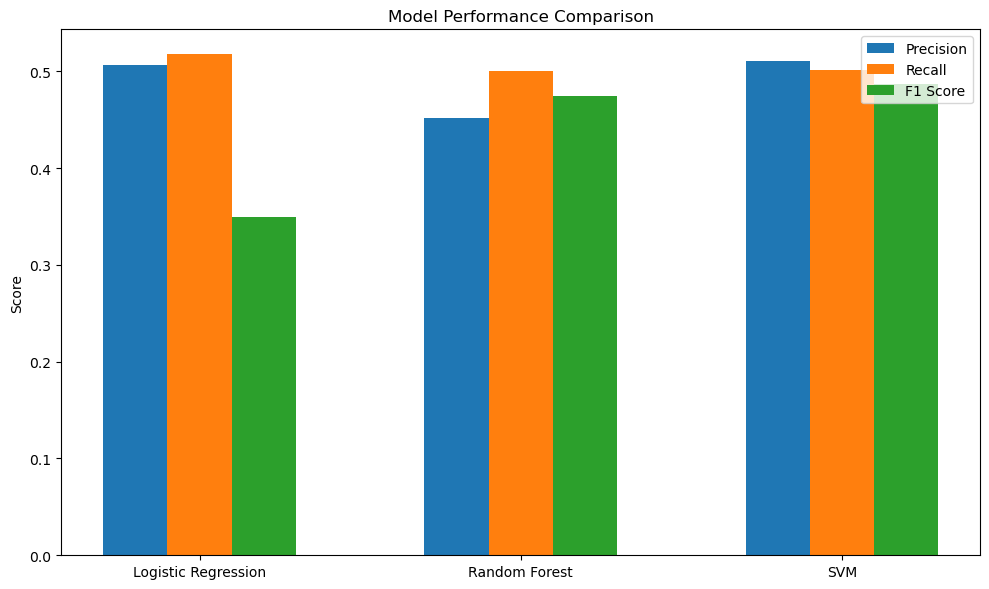

In [33]:
import matplotlib.pyplot as plt

# Plot setup
models = metrics_df['Model']
x = range(len(models))

plt.figure(figsize=(10, 6))
plt.bar(x, metrics_df['Precision'], width=0.2, label='Precision', align='center')
plt.bar([i + 0.2 for i in x], metrics_df['Recall'], width=0.2, label='Recall', align='center')
plt.bar([i + 0.4 for i in x], metrics_df['F1 Score'], width=0.2, label='F1 Score', align='center')

# Formatting
plt.xticks([i + 0.2 for i in x], models)
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()


# 6. Interpretation and Conclusion 

Based on the comparative analysis of precision, recall, and F1 score across the three models—Logistic Regression, Random Forest, and SVM—it is evident that SVM outperforms the others. While all models showed reasonable performance, SVM achieved the highest F1 Score (0.4873), indicating better balance between precision and recall in predicting smoking status. Logistic Regression, although more interpretable, lagged significantly in performance, likely due to its linear nature. Random Forest performed moderately well but was outshined by SVM. Therefore, SVM is the most suitable choice for this classification task due to its superior overall predictive capability.